# 데이콘: 이커머스 고객 세분화 분석 아이디어 경진대회
---

- 해당 대회에 대한 간단한 소개와 인사글은 README.md 파일에 작성되어 있습니다.

- 혹시 보고싶으신 분은 [이 텍스트를 클릭해주세요. 깃허브 링크로 연결됩니다](https://github.com/Randy-archive/ecommerce_seg)

---

안녕하세요, 대회에 참여하게 된 랜디Randy입니다.

RFM이나 Cohort분석에 대해서 이번 대회를 통해 더 깊게 이해해보고자 합니다.

목차는 아래와 같습니다.

# [Index]
---

1. 데이터 살펴보기

2. 온라인 마케팅 비용의 효율성

3. 지역으로 살펴보기

4. 성별로 살펴보기

5. 


15. 결론 요약


In [2]:
!pip install seaborn

You should consider upgrading via the 'C:\Users\admin\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
# 필요한 라이브러리 불러오기
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# [1. 데이터 살펴보기]

어떤 데이터가 어떤 형식으로 존재하는지 한번 살펴보도록 하겠습니다.

In [4]:
customer_data = pd.read_csv('Customer_info.csv')
discount_data = pd.read_csv('Discount_info.csv')
marketing_data = pd.read_csv('Marketing_info.csv')
onlinesales_data = pd.read_csv('Onlinesales_info.csv')
tax_data = pd.read_csv('Tax_info.csv')

customer = customer_data.copy()
discount = discount_data.copy()
marketing = marketing_data.copy()
onlinesales = onlinesales_data.copy()
tax = tax_data.copy()

print(customer.shape)
customer.head()
# 고객 ID, 성별, 고객지역, 가입기간(단위: 월)

(1468, 4)


,고객ID,성별,고객지역,가입기간
0,USER_1358,남,Chicago,12
1,USER_0190,남,California,43
2,USER_0066,남,Chicago,33
3,USER_0345,여,California,30
4,USER_0683,남,California,49


In [11]:
print(discount.shape)
discount.head()
# 월(month), 제품카테고리, 쿠폰코드, 할인율(%)

(204, 4)


,월,제품카테고리,쿠폰코드,할인율
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


In [49]:
print(marketing.shape)
marketing['날짜'] = pd.to_datetime(marketing['날짜'])
marketing.head()
# 날짜, 오프라인 마케팅으로 지출한 비용(달러), 온라인 마케팅으로 지출한 비용(달러)

(365, 3)


,날짜,오프라인비용,온라인비용
0,2019-01-01,4500,2424.50
1,2019-01-02,4500,3480.36
2,2019-01-03,4500,1576.38
3,2019-01-04,4500,2928.55
4,2019-01-05,4500,4055.30


In [50]:
print(onlinesales.shape)
onlinesales['거래날짜'] = pd.to_datetime(onlinesales['거래날짜'])
onlinesales.head()
# 고객 고유 ID, 거래 고유 ID, 거래 날짜, 제품 고유 ID, 제품 카테고리, 주문수량,
# 평균금액 (동일 상품이어도 세부 옵션에 따라 가격 상이, 단위 달러)
# 배송료(단위 달러), 쿠폰 적용 상태

(52924, 9)


,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used


In [9]:
print(tax.shape)
tax
# 제품 카테고리, Goods and Services Tax(%)

(20, 2)


,제품카테고리,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18
5,Lifestyle,0.18
6,Notebooks & Journals,0.05
7,Headgear,0.05
8,Waze,0.18
9,Fun,0.18


# [2. 온라인 마케팅 비용의 효율성]
---

`Marketing_info.csv`를 보면 날짜, 오프라인비용, 온라인 비용이 존재합니다.

온라인 비용은 날마다 바뀌지만, 오프라인 비용은 일정 기간동안 동일하다는 것을 발견했습니다.

따라서 오프라인 비용이 동일할 때, 온라인 비용이 증가하고 감소함에 따라 매출액에는 어떤 변화가 있는지 살펴보도록 하겠습니다.

In [52]:
classified_bills = []
standard = 0
tmp = pd.DataFrame()
'''
오프라인 비용이 똑같은 기간을 하나의 DataFrame으로 구성해서,
classified_bills 리스트에 각각의 DataFrame으로 저장하려고 합니다.
예를 들어 오프라인 비용이 4000달러가 고정인 채로 일주일이 지속된다면
일주일 동안의 데이터는 모두 하나의 DataFrame에 저장되고,

다음 날부터 오프라인 비용이 4500달러가 된다면
새로운 DataFrame에 오프라인비용이 4500인 행들이 쌓이게 됩니다.

날짜가 연속적일때만 하나의 DataFrame으로 삽입되며,
오프라인비용이 같다 할지라도 날짜가 연속적이지 않을 경우
별도의 DataFrame으로 구성합니다.

또한 onlinesales DataFrame에서 수량과 평균금액을 곱하여 그 날의 총 매출액을 구해
DataFrame에 삽입해주도록 하겠습니다
'''

# 그 날의 판매수량, 평균금액, 이 둘을 곱한 총매출액을 구하는 함수
def calculate_sales(date):
    daily_sales = onlinesales[onlinesales['거래날짜'] == date]

    return daily_sales['수량'].sum(), \
        daily_sales['평균금액'].sum(), \
        daily_sales['수량'].sum() * daily_sales['평균금액'].sum()

# 당일의 온라인 비용과 전일의 온라인 비용을 전달받아
# 전일 대비 비용의 증감률을 반환하는 함수
def calculate_ratio(df):
    row['비용증감'] = 0
    row['매출증감'] = 0
    for idx in range(1, len(df)):
        prev_cost = df.iloc[idx - 1]['온라인비용']
        prev_sales = df.iloc[idx - 1]['총매출액']
        df.loc[idx, '비용증감'] = ((df.loc[idx, '온라인비용'] / prev_cost) - 1) * 100
        df.loc[idx, '매출증감'] = ((df.loc[idx, '총매출액'] / prev_sales) - 1) * 100
    return df

for idx, row in marketing.iterrows():
    # 오프라인비용이 같을 땐 하나의 DataFrame으로 설정
    if row['오프라인비용'] == marketing.loc[standard]['오프라인비용']:
        tmp = pd.concat([tmp, pd.DataFrame([row])], ignore_index=True)

    # 오프라인비용이 달라지면 기존의 DataFrame을 classified_bills에 추가
    else:
        for date in tmp['날짜']:
            count, sum_price, total_sales = calculate_sales(date)
            tmp.loc[tmp['날짜'] == date, ['수량', '평균금액', '총매출액']] = count, sum_price, total_sales
        tmp = calculate_ratio(tmp)
        classified_bills.append(tmp)

        # 초기화
        standard = idx
        tmp = pd.DataFrame([row])

# 마지막 그룹 처리
if not tmp.empty:
    for date in tmp['날짜']:
        count, sum_price, total_sales = calculate_sales(date)
        tmp.loc[tmp['날짜'] == date, ['수량', '평균금액', '총매출액']] = count, sum_price, total_sales
    tmp = calculate_ratio(tmp)
    classified_bills.append(tmp)

,날짜,오프라인비용,온라인비용,비용증감,매출증감,수량,평균금액,총매출액
0,2019-11-12,4000,3390.82,0.000000,0.000000,362.0,6052.96,2191171.52
1,2019-11-13,4000,2400.95,-29.192644,85.310669,364.0,11155.15,4060474.60
2,2019-11-14,4000,855.19,-64.381182,102.525808,603.0,13637.66,8223508.98
3,2019-11-15,4000,737.08,-13.810966,-59.335459,411.0,8136.38,3344052.18
4,2019-11-16,4000,2716.48,268.546155,116.632883,742.0,9763.23,7244316.66
5,2019-11-17,4000,2964.30,9.122835,-52.899602,322.0,10596.59,3412101.98
6,2019-11-18,4000,2825.78,-4.672941,-55.533709,194.0,7820.80,1517235.20


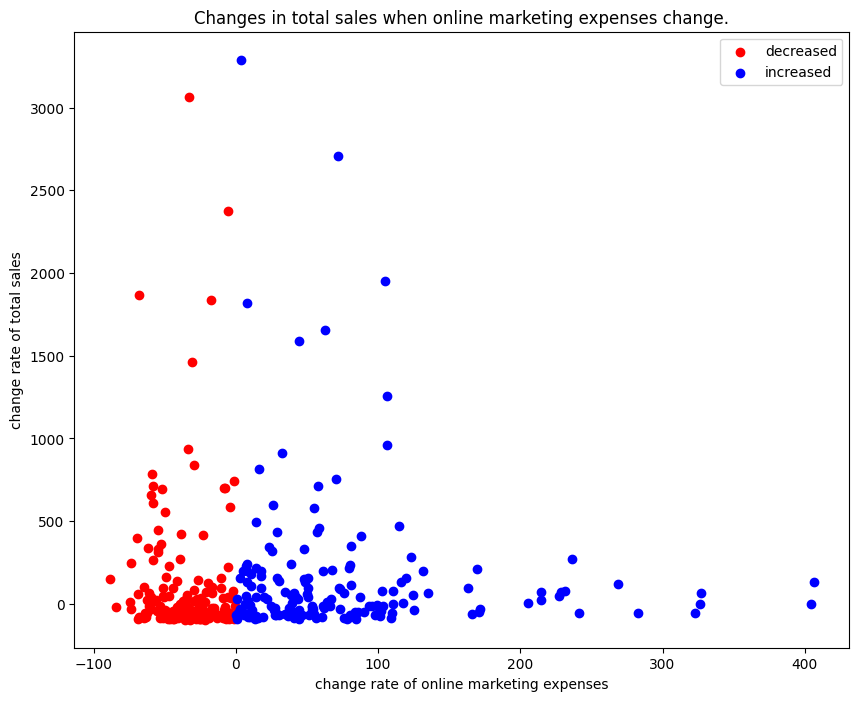

In [53]:
decreased_cost = pd.DataFrame()
increased_cost = pd.DataFrame()

'''
이제 classified_bills 안에 있는 각 데이터프레임을 순회하며
비용증감이 음수면 decreased_cost에,
비용증감이 양수면 increased_cost에 데이터를 삽입합니다.

이렇게 만들어진 두 개의 데이터프레임을 바탕으로 산점도를 그려
온라인 비용의 증감이 매출 증감에 어떤 영향을 미치는지 살펴보도록 하겠습니다.
'''

for df in classified_bills:
    decreased_cost = pd.concat([decreased_cost, df[df['비용증감'] < 0]])
    increased_cost = pd.concat([increased_cost, df[df['비용증감'] > 0]])

plt.figure(figsize=(10, 8))
# 비용증감이 음수인 경우 빨간색으로 표시
plt.scatter(decreased_cost['비용증감'], decreased_cost['매출증감'], color='red', label='decreased')
plt.scatter(increased_cost['비용증감'], increased_cost['매출증감'], color='blue', label='increased')

plt.title('Changes in total sales when online marketing expenses change.')
plt.xlabel('change rate of online marketing expenses')
plt.ylabel('change rate of total sales')
plt.legend()
plt.show()

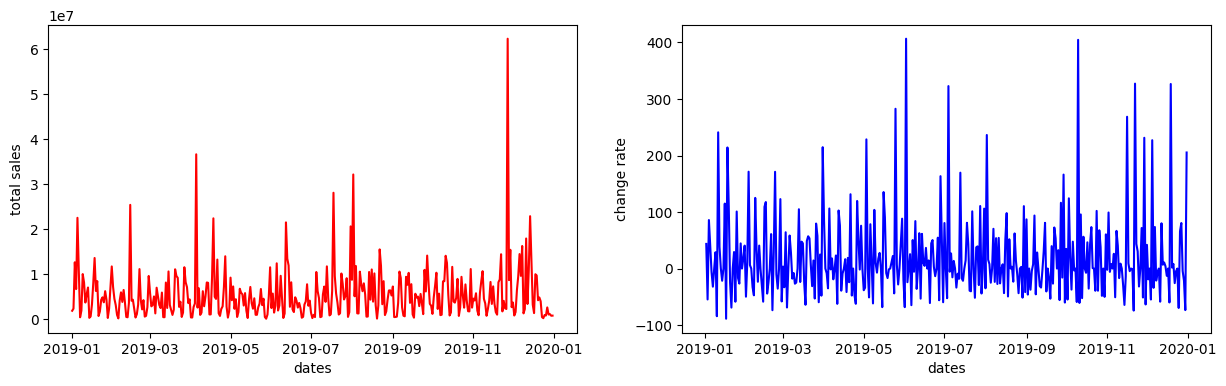

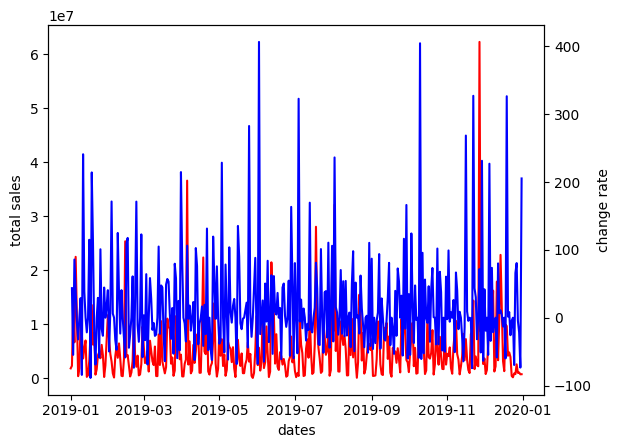

In [70]:
tmp_data = pd.DataFrame()

for df in classified_bills:
    tmp_data = pd.concat([tmp_data, df])

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(tmp_data['날짜'], tmp_data['총매출액'], color='red', label='change of total sales')
plt.xlabel('dates')
plt.ylabel('total sales')

plt.subplot(1, 2, 2)
plt.plot(tmp_data['날짜'], tmp_data['비용증감'], color='blue', label='change rate of costs')
plt.xlabel('dates')
plt.ylabel('change rate')

fig, ax1 = plt.subplots()
ax1.plot(tmp_data['날짜'], tmp_data['총매출액'], color='red', label='change of total sales')
ax1.set_xlabel('dates')
ax1.set_ylabel('total sales')

ax2 = ax1.twinx()
ax2.plot(tmp_data['날짜'], tmp_data['비용증감'], color='blue', label='change rate of costs')
ax2.set_ylabel('change rate')

plt.show()

## 분석
---

산점도로 보나, 그래프로 보나 마케팅비용과 매출액은 큰 연관성이 없어보입니다.

양의 상관관계도, 음의 상관관계도 없다는 결론을 내릴 수 있습니다.

온라인 비용이 들쭉날쭉하다는 것은

CPM이나 CPC와 같은 온라인 마케팅 비용을 효율화하기 위해

퍼포먼스 마케팅을 진행하고 있다는 것으로 유추할 수 있는데,

이러한 과정이 명시적인 성과를 내고있진 못한 것 같습니다.

추가적으로, 마케팅 비용과는 별개로 시간이 지남에 따라 매출액이 우상향하지 않는 모습을 보입니다.

즉, **해당 이커머스 플랫폼 자체의 성장이 이루어지지 않고있다는 분석**이 가능합니다.

## 발전
---

퍼포먼스 마케팅 뿐만아니라 할인쿠폰을 더 적극적으로 제공하는 등

다양한 방법을 통해 유입된 유저들의 리텐션을 유지하는 것이 중요합니다.

이에 더해 매출액 증대를 위해 다양한 품목을 이커머스 쇼핑몰에 편입하고

비용절감으로 이익률 증대를 노리는 것도 필요해보입니다.

# 결론 요약

---

## 